# Inital Preparation

In [3]:
# !pip install dotenv
!pip install kagglehub

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]


In [4]:
#libaraies

import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import joblib
import requests

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [828]:
# Download latest version
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")

print("Path to dataset files:", path)

Path to dataset files: /Users/suzukikenta/.cache/kagglehub/datasets/adampq/pokemon-tcg-all-cards-1999-2023/versions/1


In [829]:
df = pd.read_csv(os.path.join(path, "pokemon-tcg-data-master 1999-2023.csv"))

In [ ]:
# Retrieve API data
url = "https://api.pokemontcg.io/v2/cards"
headers = {
    "X-Api-Key": "706ec248-5c7b-4c86-a93c-2082a4371303"
}
params = {
    "q": "nationalPokedexNumbers:[1 TO 151]",
    "pageSize": 10
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
print(data)

{'data': [{'id': 'xy5-1', 'name': 'Weedle', 'supertype': 'Pokémon', 'subtypes': ['Basic'], 'hp': '50', 'types': ['Grass'], 'evolvesTo': ['Kakuna'], 'attacks': [{'name': 'Multiply', 'cost': ['Grass'], 'convertedEnergyCost': 1, 'damage': '', 'text': 'Search your deck for Weedle and put it onto your Bench. Shuffle your deck afterward.'}], 'weaknesses': [{'type': 'Fire', 'value': '×2'}], 'retreatCost': ['Colorless'], 'convertedRetreatCost': 1, 'set': {'id': 'xy5', 'name': 'Primal Clash', 'series': 'XY', 'printedTotal': 160, 'total': 164, 'legalities': {'unlimited': 'Legal', 'expanded': 'Legal'}, 'ptcgoCode': 'PRC', 'releaseDate': '2015/02/04', 'updatedAt': '2020/05/01 16:06:00', 'images': {'symbol': 'https://images.pokemontcg.io/xy5/symbol.png', 'logo': 'https://images.pokemontcg.io/xy5/logo.png'}}, 'number': '1', 'artist': 'Midori Harada', 'rarity': 'Common', 'flavorText': 'Its poison stinger is very powerful. Its bright-colored body is intended to warn off its enemies.', 'nationalPokedex

In [ ]:
# Retrieve the current prices of the cards
for i in range(10):
    card = data["data"][i]
    card_id = card["id"]
    prices = card["tcgplayer"]["prices"]

    # Get the first price type (e.g., 'normal', 'holofoil', etc.)
    first_price_type = list(prices.keys())[0]
    market_price = prices[first_price_type].get("market")

    print(f"ID: {card_id}, First Price Type: {first_price_type}, Market Price: {market_price}")

In [830]:
### Add Fake Prices
def add_fake_prices(df):
    # Generate fake prices for each card
    df['Price'] = df['id'].apply(lambda x: round(10 + hash(x) % 100, 2))
    return df

In [831]:
df = add_fake_prices(df)

In [832]:
df_original = df.copy()

# Explatory Data Analysis (EDA)

In [833]:
# The first 5 rows
df.head()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,convertedRetreatCost,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,Price
0,base1-1,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Alakazam,1,['Psychic'],...,3.0,Rare Holo,Its brain can outperform a supercomputer. Its ...,[65],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,28
1,base1-2,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Blastoise,2,['Water'],...,3.0,Rare Holo,A brutal Pokémon with pressurized water jets o...,[9],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,42
2,base1-3,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Chansey,3,['Colorless'],...,1.0,Rare Holo,A rare and elusive Pokémon that is said to bri...,[113],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,44
3,base1-4,Base,Base,WOTC,First,1/9/1999,Mitsuhiro Arita,Charizard,4,['Fire'],...,3.0,Rare Holo,Spits fire that is hot enough to melt boulders...,[6],{'unlimited': 'Legal'},"[{'type': 'Fighting', 'value': '-30'}]",NaN,NaN,NaN,34
4,base1-5,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Clefairy,5,['Colorless'],...,1.0,Rare Holo,Its magical and cute appeal has many admirers....,[35],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,79


In [834]:
# The last 5 rows
df.tail()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,convertedRetreatCost,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,Price
17167,sv4-262,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,takuyoa,Roaring Moon ex,262,['Darkness'],...,2.0,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,['Pokémon ex rule: When your Pokémon ex is Kno...,G,NaN,23
17168,sv4-263,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Oswaldo KATO,Beach Court,263,NaN,...,NaN,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""The Retreat Cost of each Basic Pokémon in pl...",G,NaN,61
17169,sv4-264,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Counter Catcher,264,NaN,...,NaN,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""You can use this card only if you have more ...",G,NaN,63
17170,sv4-265,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Luxurious Cape,265,NaN,...,NaN,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""If the Pokémon this card is attached to does...",G,NaN,107
17171,sv4-266,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,NaN,Reversal Energy,266,NaN,...,NaN,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""As long as this card is attached to a Pokémo...",G,NaN,24


In [835]:
# Basics
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17172 entries, 0 to 17171
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17172 non-null  object 
 1   set                     17172 non-null  object 
 2   series                  17172 non-null  object 
 3   publisher               17172 non-null  object 
 4   generation              17172 non-null  object 
 5   release_date            17172 non-null  object 
 6   artist                  16951 non-null  object 
 7   name                    17172 non-null  object 
 8   set_num                 17172 non-null  object 
 9   types                   14500 non-null  object 
 10  supertype               17172 non-null  object 
 11  subtypes                16998 non-null  object 
 12  level                   2404 non-null   object 
 13  hp                      14536 non-null  float64
 14  evolvesFrom             6165 non-null 

id                            0
set                           0
series                        0
publisher                     0
generation                    0
release_date                  0
artist                      221
name                          0
set_num                       0
types                      2672
supertype                     0
subtypes                    174
level                     14768
hp                         2636
evolvesFrom               11007
evolvesTo                 11382
abilities                 13744
attacks                    2663
weaknesses                 3078
retreatCost                3494
convertedRetreatCost       3494
rarity                      295
flavorText                 7449
nationalPokedexNumbers     2774
legalities                    0
resistances               12891
rules                     11972
regulationMark            12240
ancientTrait              17113
Price                         0
dtype: int64

## Inital Elimination

In [836]:
# Drop Non-Pokoemon Card
df = df[df["supertype"] == "Pokémon"]

In [837]:
# Drop Columns with Too Many NaNs
def drop_columns_with_too_many_nans(df, threshold=0.80):
    # Calculate the threshold for NaN values
    nan_threshold = len(df) * threshold
    # Drop columns with NaN values above the threshold
    df_cleaned = df.dropna(thresh=nan_threshold, axis=1)
    return df_cleaned
df = drop_columns_with_too_many_nans(df)

In [838]:
# Rows
print("Number of rows:", len(df))

Number of rows: 14497


# Feature Selection(Only columns you absolutely cannot use)

In [839]:
# Valid Columns
df.columns

Index(['id', 'set', 'series', 'publisher', 'generation', 'release_date',
       'artist', 'name', 'set_num', 'types', 'supertype', 'subtypes', 'hp',
       'attacks', 'weaknesses', 'retreatCost', 'convertedRetreatCost',
       'rarity', 'nationalPokedexNumbers', 'legalities', 'Price'],
      dtype='object')

## Set

In [840]:
# how many sets
print("Number of unique sets:", df['set'].nunique())

Number of unique sets: 155


In [841]:
# Display full value counts
print(df["set"].value_counts())

set
SWSH Black Star Promos                290
SM Black Star Promos                  247
Fusion Strike                         245
Paldea Evolved                        238
Cosmic Eclipse                        229
Paradox Rift                          222
Unified Minds                         216
Obsidian Flames                       210
Scarlet & Violet                      209
Shiny Vault                           206
Unbroken Bonds                        196
XY Black Star Promos                  194
Evolving Skies                        193
Lost Thunder                          192
151                                   185
Silver Tempest                        177
Lost Origin                           177
Rebel Clash                           176
Sword & Shield                        173
Darkness Ablaze                       172
Chilling Reign                        168
Astral Radiance                       167
Vivid Voltage                         166
Skyridge                      

❌ Too many rows

## Series

In [842]:
# how many series
print("Number of unique sets:", df['series'].nunique())

Number of unique sets: 16


In [843]:
# All the series
print(df["series"].value_counts())

series
Sword & Shield            3038
Sun & Moon                2449
XY                        1586
EX                        1486
Black & White             1289
Scarlet & Violet          1119
Diamond & Pearl            798
HeartGold & SoulSilver     467
Platinum                   464
E-Card                     444
Base                       406
Neo                        311
Other                      282
Gym                        186
POP                        136
NP                          36
Name: count, dtype: int64


⭕️ Interesting

## Publisher

In [844]:
# how many publishers
print("Number of unique sets:", df['publisher'].nunique())

Number of unique sets: 2


❌ It is very unlikey that a publisher has influence on the price

## Generations

In [845]:
## how many generations
print("Number of unique generations:", df['generation'].nunique())

Number of unique generations: 11


In [846]:
# Show all rows when printing
pd.set_option("display.max_rows", None)

# Display full value counts
print(df["generation"].value_counts())

generation
Eighth     3038
Seventh    2449
Third      1593
Fifth      1483
Sixth      1392
Fourth     1274
Ninth      1119
Second      880
First       592
Fourth      520
Other       157
Name: count, dtype: int64


⭕️ LGTM 

## Relase Data

❌ It is useless as we have generations and series

## Artists

In [847]:
# how many artists
print("Number of unique sets:", df['artist'].nunique())

Number of unique sets: 285


❌ Too many categories

## Types

In [848]:
## how many generations
print("Number of unique generations:", df['types'].nunique())

Number of unique generations: 36


In [849]:
# Show all rows when printing
pd.set_option("display.max_rows", None)

# Display full value counts
print(df["types"].value_counts())

types
['Water']                    2088
['Grass']                    2010
['Psychic']                  1940
['Colorless']                1866
['Fighting']                 1566
['Fire']                     1284
['Lightning']                1271
['Darkness']                  945
['Metal']                     757
['Dragon']                    433
['Fairy']                     234
['Grass', 'Darkness']          10
['Lightning', 'Metal']          9
['Fighting', 'Darkness']        9
['Darkness', 'Metal']           7
['Water', 'Metal']              7
['Water', 'Darkness']           7
['Fire', 'Metal']               6
['Psychic', 'Metal']            5
['Fire', 'Darkness']            5
['Lightning', 'Darkness']       5
['Fighting', 'Metal']           4
['Fire', 'Water']               4
['Psychic', 'Darkness']         3
['Grass', 'Metal']              3
['Darkness', 'Psychic']         2
['Metal', 'Fighting']           2
['Water', 'Fire']               2
['Colorless', 'Psychic']        2
['Water'

In [850]:
df["single_type"] = df["types"].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x else None)

In [851]:
print(df["single_type"].value_counts())

single_type
Water        2106
Grass        2023
Psychic      1948
Colorless    1868
Fighting     1579
Fire         1302
Lightning    1288
Darkness      954
Metal         759
Dragon        433
Fairy         237
Name: count, dtype: int64


⭕️if I eliminate pokeomon  with two types, looks good

## subtypes

In [852]:
## how many types
print("Number of unique generations:", df['subtypes'].nunique())

Number of unique generations: 67


In [853]:
# Show all rows when printing
pd.set_option("display.max_rows", None)

# Display full value counts
print(df["subtypes"].value_counts())

subtypes
['Basic']                                                      6554
['Stage 1']                                                    3827
['Stage 2']                                                    1179
['Basic', 'V']                                                  517
['Basic', 'EX']                                                 390
['Basic', 'GX']                                                 176
['VMAX']                                                        152
['Stage 1', 'GX']                                               148
['Basic', 'TAG TEAM', 'GX']                                     111
['Stage 2', 'GX']                                                99
['VSTAR']                                                        94
['MEGA', 'EX']                                                   92
['Basic', 'SP']                                                  85
['Basic', 'ex']                                                  61
['Level-Up']                           

❌ Too many categories 

## HP

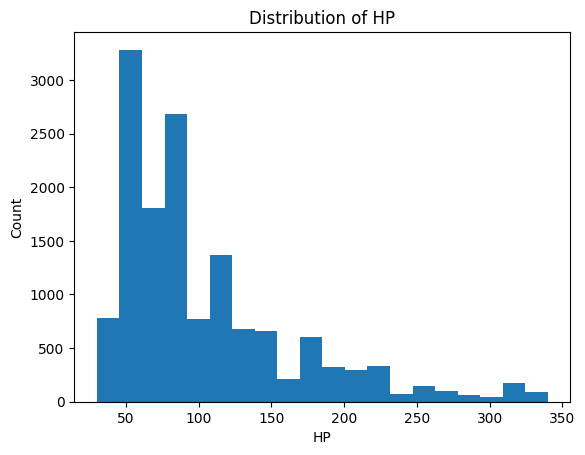

In [854]:
plt.hist(df["hp"].dropna(), bins=20)
plt.title("Distribution of HP")
plt.xlabel("HP")
plt.ylabel("Count")
plt.show()

⭕️ looks relavent to the price

## Attacks

In [855]:
df["attacks"][0]

"[{'name': 'Confuse Ray', 'cost': ['Psychic', 'Psychic', 'Psychic'], 'convertedEnergyCost': 3, 'damage': '30', 'text': 'Flip a coin. If heads, the Defending Pokémon is now Confused.'}]"

In [856]:
def extract_damage_with_symbol(attacks_str):
    if pd.isnull(attacks_str):
        return None
    try:
        attacks = ast.literal_eval(attacks_str)
        if isinstance(attacks, list) and len(attacks) > 0:
            last_attack = attacks[-1]
            damage = last_attack.get('damage', '')
            # Corrected regex pattern here:
            match = re.search(r'(\d+[+x]?)', damage)
            if match:
                return match.group(1)
            else:
                return None
    except Exception as e:
        print(f"Exception: {e}")
        return None

df['last_attack_damage'] = df['attacks'].apply(extract_damage_with_symbol)


In [857]:
df["last_attack_damage"]

0          30
1         40+
2          80
3         100
4        None
5          40
6          40
7          60
8          80
9        None
10         20
11         80
12         40
13         60
14         60
15        100
16         40
17         20
18         70
19        30+
20         50
21       None
22         80
23         50
24         30
25         10
26         30
27         20
28         50
29         20
30        20+
31         50
32         20
33         60
34         10
35         50
36         50
37         30
38       None
39       None
40         10
41         40
42         10
43         20
44         10
45         30
46         30
47         10
48         10
49       None
50         10
51         20
52         40
53         20
54         30
55       None
56         10
57         30
58        10+
59         30
60         20
61         10
62       None
63         20
64         20
65         20
66         10
67         10
68         10
102      None
103        20
104   

In [858]:
# Null rate
null_rate = df['last_attack_damage'].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 11.298889425398357%


🔺 It might be hard to handle with both the ones with symbols and null values

## Weakness

In [859]:
df["weaknesses"]

0                     [{'type': 'Psychic', 'value': '×2'}]
1                   [{'type': 'Lightning', 'value': '×2'}]
2                    [{'type': 'Fighting', 'value': '×2'}]
3                       [{'type': 'Water', 'value': '×2'}]
4                    [{'type': 'Fighting', 'value': '×2'}]
5                       [{'type': 'Grass', 'value': '×2'}]
6                     [{'type': 'Psychic', 'value': '×2'}]
7                     [{'type': 'Psychic', 'value': '×2'}]
8                    [{'type': 'Fighting', 'value': '×2'}]
9                     [{'type': 'Psychic', 'value': '×2'}]
10                    [{'type': 'Psychic', 'value': '×2'}]
11                      [{'type': 'Water', 'value': '×2'}]
12                      [{'type': 'Grass', 'value': '×2'}]
13                   [{'type': 'Fighting', 'value': '×2'}]
14                       [{'type': 'Fire', 'value': '×2'}]
15                                                     NaN
16                       [{'type': 'Fire', 'value': '×2'

❌ looks irrelevent

## Retreat Cost

In [860]:
df["retreatCost"]

0                  ['Colorless', 'Colorless', 'Colorless']
1                  ['Colorless', 'Colorless', 'Colorless']
2                                            ['Colorless']
3                  ['Colorless', 'Colorless', 'Colorless']
4                                            ['Colorless']
5                  ['Colorless', 'Colorless', 'Colorless']
6                               ['Colorless', 'Colorless']
7                  ['Colorless', 'Colorless', 'Colorless']
8                                            ['Colorless']
9                  ['Colorless', 'Colorless', 'Colorless']
10                 ['Colorless', 'Colorless', 'Colorless']
11                                           ['Colorless']
12                 ['Colorless', 'Colorless', 'Colorless']
13                                           ['Colorless']
14                              ['Colorless', 'Colorless']
15                 ['Colorless', 'Colorless', 'Colorless']
16                                                     N

❌You can use convertedRetreatCost

## convertedRetreatCost

In [861]:
df["convertedRetreatCost"]

0        3.0
1        3.0
2        1.0
3        3.0
4        1.0
5        3.0
6        2.0
7        3.0
8        1.0
9        3.0
10       3.0
11       1.0
12       3.0
13       1.0
14       2.0
15       3.0
16       NaN
17       2.0
18       2.0
19       2.0
20       1.0
21       1.0
22       3.0
23       1.0
24       3.0
25       1.0
26       1.0
27       1.0
28       1.0
29       1.0
30       2.0
31       3.0
32       2.0
33       3.0
34       1.0
35       2.0
36       1.0
37       1.0
38       1.0
39       1.0
40       1.0
41       1.0
42       NaN
43       1.0
44       1.0
45       1.0
46       NaN
47       NaN
48       1.0
49       NaN
50       1.0
51       1.0
52       1.0
53       2.0
54       1.0
55       3.0
56       1.0
57       1.0
58       1.0
59       1.0
60       NaN
61       1.0
62       1.0
63       1.0
64       1.0
65       2.0
66       1.0
67       1.0
68       1.0
102      2.0
103      1.0
104      1.0
105      1.0
106      3.0
107      1.0
108      3.0
109      NaN

In [862]:
# Null rate
null_rate = df["convertedRetreatCost"].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 5.649444712699179%


## rarity

In [863]:
# how many sets
print("Number of unique sets:", df['rarity'].nunique())

Number of unique sets: 31


In [864]:
df['rarity'].value_counts()

rarity
Common                       4137
Uncommon                     2654
Rare                         2214
Rare Holo                    1550
Promo                        1045
Rare Ultra                    536
Rare Holo EX                  318
Rare Holo V                   282
Rare Rainbow                  244
Rare Holo GX                  165
Rare Secret                   152
Rare Shiny                    149
Illustration Rare             122
Rare Holo VMAX                110
Double Rare                    82
Trainer Gallery Rare Holo      80
Ultra Rare                     68
Rare Holo LV.X                 56
Rare Holo VSTAR                44
Rare Shiny GX                  35
Special Illustration Rare      33
Rare BREAK                     27
Rare Prime                     26
Rare Holo Star                 25
Classic Collection             22
LEGEND                         18
Rare Prism Star                16
Rare Shining                   16
Radiant Rare                   15
Hyper R

In [ ]:
rarity_group = {
    "Common": "Common",
    "Uncommon": "Common",

    "Promo": "Uncommon",
    "Trainer Gallery Rare Holo": "Uncommon",

    "Rare": "Rare",
    "Rare Holo": "Rare",
    "Rare Ultra": "Rare",
    "Rare Holo EX": "Rare",
    "Rare Holo V": "Rare",
    "Rare Holo GX": "Rare",
    "Rare Holo VMAX": "Rare",
    "Rare Rainbow": "Rare",
    "Rare Shiny": "Rare",
    "Rare Shiny GX": "Rare",
    "Rare Shining": "Rare",
    "Radiant Rare": "Rare",
    "Rare Secret": "Rare",

    "Double Rare": "Very Rare",
    "Rare BREAK": "Very Rare",
    "Rare Prime": "Very Rare",
    "Rare Holo LV.X": "Very Rare",
    "Rare Holo VSTAR": "Very Rare",
    "Rare Holo Star": "Very Rare",
    "Rare Prism Star": "Very Rare",

    "Illustration Rare": "Special Rare",
    "Special Illustration Rare": "Special Rare",
    "Classic Collection": "Special Rare",
    "LEGEND": "Special Rare",
    "Hyper Rare": "Special Rare",
    "Amazing Rare": "Special Rare"
}

df['rarity_grouped'] = df['rarity'].map(rarity_group)


In [866]:
df["rarity_grouped"].value_counts()

rarity_grouped
Common          6791
Rare            5786
Uncommon        1125
Very Rare        276
Special Rare     216
Name: count, dtype: int64

⭕️looks useful

## legalities

In [867]:
df["legalities"].value_counts()

legalities
{'unlimited': 'Legal', 'expanded': 'Legal'}                         6496
{'unlimited': 'Legal'}                                              4881
{'unlimited': 'Legal', 'standard': 'Legal', 'expanded': 'Legal'}    3100
{'unlimited': 'Legal', 'expanded': 'Banned'}                          14
{'unlimited': 'Banned'}                                                6
Name: count, dtype: int64

❌It is hard to understand what are leagal

## Useful columns

In [868]:
columns = ["id", "series","generation", "single_type","hp", "last_attack_damage", "convertedRetreatCost","rarity_grouped","Price"]

In [869]:
df = df[columns]
df.head()

,id,series,generation,single_type,hp,last_attack_damage,convertedRetreatCost,rarity_grouped,Price
0,base1-1,Base,First,Psychic,80.0,30,3.0,Rare,28
1,base1-2,Base,First,Water,100.0,40+,3.0,Rare,42
2,base1-3,Base,First,Colorless,120.0,80,1.0,Rare,44
3,base1-4,Base,First,Fire,120.0,100,3.0,Rare,34
4,base1-5,Base,First,Colorless,40.0,None,1.0,Rare,79


# Data Cleaning

In [870]:
df.head()

,id,series,generation,single_type,hp,last_attack_damage,convertedRetreatCost,rarity_grouped,Price
0,base1-1,Base,First,Psychic,80.0,30,3.0,Rare,28
1,base1-2,Base,First,Water,100.0,40+,3.0,Rare,42
2,base1-3,Base,First,Colorless,120.0,80,1.0,Rare,44
3,base1-4,Base,First,Fire,120.0,100,3.0,Rare,34
4,base1-5,Base,First,Colorless,40.0,None,1.0,Rare,79


In [871]:
df.isna().sum()

id                         0
series                     0
generation                 0
single_type                0
hp                         0
last_attack_damage      1638
convertedRetreatCost     819
rarity_grouped           303
Price                      0
dtype: int64

In [872]:
# You might be able to use last_attack_damage to predict the price but for now we will drop it
df = df.drop(columns=["last_attack_damage"])

In [873]:
df = df.dropna()
df.isna().sum()

id                      0
series                  0
generation              0
single_type             0
hp                      0
convertedRetreatCost    0
rarity_grouped          0
Price                   0
dtype: int64

# Pipeline(Feature Engineering,Train_Test_Split,Modeling and Evaluation)

In [874]:
df.columns

Index(['id', 'series', 'generation', 'single_type', 'hp',
       'convertedRetreatCost', 'rarity_grouped', 'Price'],
      dtype='object')

In [875]:
# Pipeline for Machine Learning
X = df.columns.drop("Price")
y = ["Price"]

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

# Identify categorical and numeric columns
categorical_cols = ['series', 'generation','single_type','rarity_grouped']  # example categorical columns
numeric_cols = ['hp', 'convertedRetreatCost']  # example numeric columns

# Define preprocessing for categorical data: OneHotEncoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define preprocessing for numeric data: scaling
numeric_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

# Create the full pipeline including the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit pipeline on training data (this fits preprocessing and the model)
pipeline.fit(X_train, y_train)

# Predict or evaluate on test data (this applies the exact same preprocessing)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

/Users/suzukikenta/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: -0.21554558746681085


In [876]:
# Features for the model

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['cat__series_Base' 'cat__series_Black & White'
 'cat__series_Diamond & Pearl' 'cat__series_E-Card' 'cat__series_EX'
 'cat__series_Gym' 'cat__series_HeartGold & SoulSilver' 'cat__series_NP'
 'cat__series_Neo' 'cat__series_Other' 'cat__series_POP'
 'cat__series_Platinum' 'cat__series_Scarlet & Violet'
 'cat__series_Sun & Moon' 'cat__series_Sword & Shield' 'cat__series_XY'
 'cat__generation_Eighth' 'cat__generation_Fifth' 'cat__generation_First'
 'cat__generation_Fourth' 'cat__generation_Fourth '
 'cat__generation_Ninth' 'cat__generation_Other' 'cat__generation_Second'
 'cat__generation_Seventh' 'cat__generation_Sixth' 'cat__generation_Third'
 'cat__single_type_Colorless' 'cat__single_type_Darkness'
 'cat__single_type_Dragon' 'cat__single_type_Fairy'
 'cat__single_type_Fighting' 'cat__single_type_Fire'
 'cat__single_type_Grass' 'cat__single_type_Lightning'
 'cat__single_type_Metal' 'cat__single_type_Psychic'
 'cat__single_type_Water' 'cat__rarity_grouped_Common'
 'cat__rarity_grouped_Rar

# Pipeline(Grid Search)

In [877]:
param_grid = [
    {
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [None, 10]
    },
    {
        'regressor': [GradientBoostingRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.05, 0.1]
    },
    {
        'regressor': [SVR()],
        'regressor__kernel': ['linear', 'rbf'],
        'regressor__C': [0.1, 1, 10]
    }
]


In [878]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())  # Flatten y to 1D if it's a DataFrame

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['series',
                                                                          'generation',
                                                                          'single_type',
                                                                          'rarity_grouped']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['hp',
                                                                          'convertedRetreatCost'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'regressor': [LinearR...
                         {'regressor': [RandomForestRegressor(random_state=42)],
                          'regressor__max_depth': [None, 10],
                          'regressor__n_estimators': [50, 100]},
                         {'regressor': [GradientBoostingRegressor(random_state=42)],
                          'regressor__learning_rate': [0.05, 0.1],
                          'regressor__n_estimators': [50, 100]},
                         {'regressor': [SVR()], 'regressor__C': [0.1, 1, 10],
                          'regressor__kernel': ['linear', 'rbf']}],
             scoring='r2', verbose=1)

In [879]:
print("Best parameters:", grid_search.best_params_)
print("Best R² score on CV:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test R² score:", r2_score(y_test, y_pred))


Best parameters: {'regressor': SVR(), 'regressor__C': 0.1, 'regressor__kernel': 'rbf'}
Best R² score on CV: -0.0016894188533350895
Test R² score: -0.0001871591701032571


# Save the model

In [880]:
# Save the model
joblib.dump(grid_search.best_estimator_, "pokemon_price_model.pkl")

['pokemon_price_model.pkl']

# How the model takes an input(Overvalued or Undervalued?)

In [881]:
model = joblib.load('pokemon_price_model.pkl')

# You can now use it to predict
y_pred = model.predict(new_data)
y_pred

array([61.05375876])

In [882]:
# New data just with id
new_data = df[df["id"]=="xy5-2"]
new_data

,id,series,generation,single_type,hp,convertedRetreatCost,rarity_grouped,Price
7949,xy5-2,XY,Sixth,Grass,80.0,3.0,Common,25


In [883]:
if new_data["Price"].values[0] > model.predict(new_data):
    print("Overvalued!")
else:
    print("Undervalued!")

Undervalued!


# How the model takes an input(Recommendation with Budget)

In [884]:
# Original List that contains only cards whose prices can be predicted
df_original["single_type"] = df["single_type"]
df_original["rarity_grouped"] = df["rarity_grouped"]
df_original = df_original[df_original["supertype"] == "Pokémon"]
df_original = df_original.dropna(subset=['single_type', 'rarity_grouped'])


In [885]:
df_original["predicted_price"] = model.predict(df_original[X])

In [886]:
df_original.head()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,Price,single_type,rarity_grouped,predicted_price
0,base1-1,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Alakazam,1,['Psychic'],...,[65],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,28,Psychic,Rare,60.446106
1,base1-2,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Blastoise,2,['Water'],...,[9],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,42,Water,Rare,60.121061
2,base1-3,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Chansey,3,['Colorless'],...,[113],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,44,Colorless,Rare,59.914612
3,base1-4,Base,Base,WOTC,First,1/9/1999,Mitsuhiro Arita,Charizard,4,['Fire'],...,[6],{'unlimited': 'Legal'},"[{'type': 'Fighting', 'value': '-30'}]",NaN,NaN,NaN,34,Fire,Rare,60.464950
4,base1-5,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Clefairy,5,['Colorless'],...,[35],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,79,Colorless,Rare,60.205419


In [892]:
# Find the best cards withting the budget
budget = int(input("Enter your budget:"))
poke_type = input("Enter the type: ")

# Filter by budget and type
filtered_df = df_original[(df_original["Price"] <= budget) & (df_original["single_type"] == poke_type)]
filtered_df[filtered_df["predicted_price"] == filtered_df["predicted_price"].max()]

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,Price,single_type,rarity_grouped,predicted_price
13814,swsh6-38,Chilling Reign,Sword & Shield,TPCI,Eighth,6/18/2021,tetsuya koizumi,Sealeo,38,['Water'],...,[364],"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,NaN,E,NaN,40,Water,Common,61.060437
